In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from tqdm.notebook import *
import tdpkefm

from tdpkefm import *
import glob
import json_tricks
import copy

In [3]:
def get_basic_phase_error(dataset):
    sps = dataset["val"]
    return {'dphi_est_mcyc': sps['dphi_est'], 'percent_error': sps['error']*100, 'dphi_act_mcyc': sps['dphi_est']/(1 + sps['error']),
            'x0': sps['sol'][0, 0]*1000, 'tp': sps['V']['tp'], "Czz_q": sps['sim']['Czz_q'], "DCzz": sps['sim']['DCzz'], "Cs": sps['sim']['Cs']}

def basic_phase_error_data(dataset):
    d = copy.copy(dataset)
    sps = dataset["val"]
    d['tp'] = sps['V']['tp']
    d['DCzz'] = sps['sim']['DCzz']
    d["Czz_q"] = sps['sim']['Czz_q']
    d['Cs'] = sps['sim']['Cs']
    return d

def make_R_V_simCs(x):
    R = Resistance(**x['val']['R'])
    V = Voltage(**x['val']['V'])
    simDict = copy.copy(x['val']['sim'])
    simDict['f0'] = simDict['omega0'] / (2*np.pi)
    del simDict['omega0']
    del simDict['DCzz']
    del simDict['Czz_q']
    simCs = SimCs(V, R, **simDict)
    return R, V, simCs

def equal_except_for(x, y, key, val=None):
    keys = [k for k in x.keys() if k != 'val' and k not in key]
    top_level_keys = all((x[k] == y[k] for k in keys))
    return top_level_keys

def add_top_level(y):
    z = copy.copy(y)
    z['Cz'] = z['val']['sim']['Cz']
    z['Cs'] = z['val']['sim']['Cs']
    z['tp'] = z['val']['V']['tp']
    z['Czz'] = z['val']['sim']['Czz']
    return z

def print_shorter(x):
    y = copy.copy(x)
    del y['val']
    return y

In [6]:
mpl.rc('font', size=8)
d = json_tricks.load("results/S13-data.json.gz", decompression=True, conv_str_byte=True)
d2 = [add_top_level(y) for y in d]

# Simulations

In [8]:
R, V, sim = make_R_V_simCs(d[1070])
ts = d[1070]['val']['t']
sol = d[1070]['val']['sol']

R2, V2, sim2 = make_R_V_simCs(d[1139])
ts2 = d[1139]['val']['t']
sol2 = d[1139]['val']['sol']

Vt0 = np.array([sim.qt0(sol_r, t_)/sim.C for t_, sol_r in zip(ts, sol)])
Vt1 = np.array([sim2.qt0(sol_r, t_)/sim2.C for t_, sol_r in zip(ts, sol2)])

In [9]:
t = np.array([0,     40,   80,   120,    160,   200, 240, 280])
omegas = np.logspace(-4, 0.5, 80)
vals = np.array([[sim.responseReCs(t_+8, omega_) for omega_ in omegas] for t_ in t])

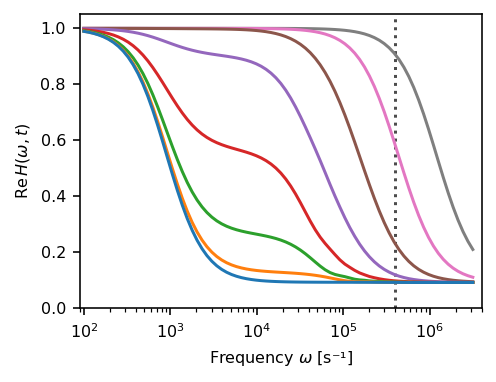

In [10]:

fig = plt.figure(figsize=(5*3.6/5, 3.75*3.6/5))
for t_, row in zip(t, vals):
    line, = plt.semilogx(1e6*omegas, row, label=t_, zorder=t[-1]-t_+1,
#                          marker=m, markevery=3, markersize=4.5
                        )

plt.axvline(sim.omega0*1e6, color='0.3', zorder=-1,  linestyle=':')
# plt.legend()
plt.ylim(0, 1.05)
plt.xlim(0.9e2, 0.4e7)
plt.xlabel("Frequency $\\omega$ [s⁻¹]")
plt.ylabel("$\\mathrm{Re}\, H(\\omega, t)$")
plt.savefig("figs/S1a.pdf", bbox_inches='tight', transparent=True)

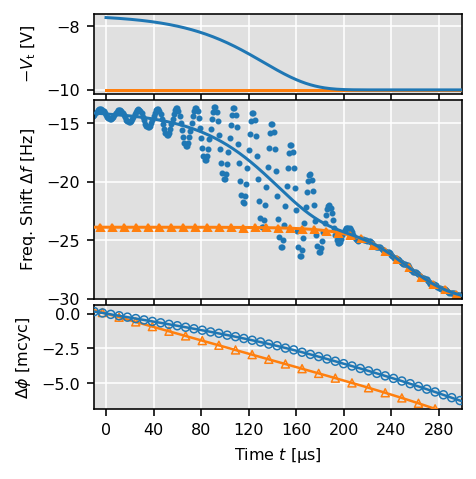

In [12]:
dec = [2, 2, 3, 3, 4]
colors = []
decs1 = [1, 10]
decs = [7, 14]
fig, axes = plt.subplots(nrows=3, figsize=(5*3.3/5, 5.5*3.3/5), sharex=True, gridspec_kw=dict(hspace=0.05, height_ratios=[1, 2.5, 1.3]))
i = 10
markers= ['.', '^']
markers2 = ['o', '^']
markersize=[4,3.5]
for mark, marksize, mark2, dec1, dec, ds in zip(markers, markersize, markers2, decs1, decs, [d[1070], d[1139]]):
    colors.append(axes[1].plot(ds['val']['t'][15::dec1], ds['val']['df'][::dec1]*1e6/(2*np.pi), mark,
                               markersize=marksize)[0].get_color())
    df_python_filt = np.convolve(ds['val']['df_python'], np.ones(16)/16.0, 'valid')
    axes[1].plot(ds['val']['t'][30:], df_python_filt, '-', color=colors[-1], linewidth=1.5, zorder=i)
    
    axes[-1].scatter(ds['val']['t'][15::dec],
                     ds['val']['dphi'][::dec] - ds['val']['dphi'][185], s=16, marker=mark2,
                     facecolors='none', edgecolors=colors[-1], zorder=i-1, linewidth=0.75)
    phase = np.cumsum(np.convolve(ds['val']['df_python']*1e-3, # Convert to mcyc
                                  np.ones(16)/16.0, 'valid'))
    
    axes[-1].plot(ds['val']['t'][30:], phase-phase[170], '-',
                  color=colors[-1], linewidth=1.25, zorder=i)
    
    i += -2
    
    


m = (ts>=0)&(ts<300)
axes[0].plot(ts[m], -Vt0[m], zorder=10)
axes[0].plot(ts[m], -Vt1[m], zorder=9)

# plt.xlabel("t [µs]")
axes[0].set_ylabel('$-V_{\mathrm{t}}$ [V]')
    
axes[1].plot(-25, -29, '.', color='k', label="Num. integration")
axes[1].plot(-25, -29, '-', color='k', label="Impedance approx.")
axes[1].set_ylim(-30, -13)
axes[1].set_xlim(-10, 300)
# plt.text(-3, -30, "$\\tau_{\\mathrm{L}} = $ 10 µs", color=colors[0])
# plt.text(77, -29.95, "20 µs", color=colors[1])
# plt.text(125, -29.75, "40 µs", color=colors[2])
# plt.text(165, -28.30, "80 µs", color=colors[3])
# plt.text(175, -25.5, "160 µs", color=colors[4])
axes[-1].set_xlabel(u"Time $t$ [µs]")
axes[1].set_ylabel(u"Freq. Shift $\\Delta f$ [Hz]")

axes[2].set_ylabel("$\\Delta \\phi$ [mcyc]")
axes[2].set_ylim(-6.8, 0.6)
# axes[1].legend()
axes[1].set_yticks([-15, -20, -25, -30])
axes[-1].set_xticks(np.arange(0, 300, 40))
fc = "0.88"
for ax in axes:
    ax.grid(color='1', zorder=-2)
    ax.set_facecolor(fc)
# axes[1].grid(axis='x', color='1')
# axes[2].grid(axis='x', color='1')
plt.savefig('figs/S1bcd.pdf', facecolor=fig.get_facecolor(), edgecolor='none')

